# systematics with the Asimov dataset

To assess the impact of various sources of systematic, we will rely on an Asimov dataset.

In [1]:
## imports and configuration
%cd '/home/naodell/work/wbr/analysis'

from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import minimize
from tqdm import tqdm_notebook

import scripts.plot_tools as pt
import scripts.fit_helpers as fh
from nllfit.nllfitter import ScanParameters

np.set_printoptions(precision=3)
matplotlib.style.use('default')
params = {'legend.fontsize': 20,
          'axes.labelsize': 20,
          'figure.figsize': (8, 8),
          'axes.facecolor': 'white',
          'axes.titlesize':'x-large',
          'xtick.labelsize':18,
          'ytick.labelsize':18,
         }
matplotlib.rcParams.update(params)
%matplotlib inline
%connect_info

/home/naodell/work/wbr/analysis
{
  "shell_port": 45701,
  "iopub_port": 45199,
  "stdin_port": 55083,
  "control_port": 45237,
  "hb_port": 36939,
  "ip": "127.0.0.1",
  "key": "af463c44-ea250ce6aa397f0d8611a03a",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-f554514e-395f-4ab2-9743-2fa613598971.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


In [2]:
# configure, get the input data, and do any additional processing that is needed
input_dir  = f'local_data/templates/btag_fix/'
selections = [
              'emu', 
              'mumu',  'mutau',  'mu4j',
              'ee',  'etau', 'e4j'
             ]
n_selection = len(selections)
targets    = dict(
                  mumu  = 'lepton2_pt', 
                  ee    = 'lepton2_pt', 
                  emu   = 'trailing_lepton_pt', 
                  mutau = 'lepton2_pt', 
                  etau  = 'lepton2_pt', 
                  mu4j  = 'lepton1_pt',
                  e4j   = 'lepton1_pt'
                 )
plot_labels = dict(
                   mumu  = [r'$\sf p_{T, \mu}$', r'$\mu\mu$'],
                   ee    = [r'$\sf p_{T, e}$', r'$ee$'],
                   emu   = [r'$\sf p_{T, \ell}$', r'$e\mu$'],
                   mutau = [r'$\sf p_{T, \tau}$', r'$\mu\tau$'],
                   etau  = [r'$\sf p_{T, \tau}$', r'$e\tau$'],
                   mu4j  = [r'$\sf p_{T, \mu}$', r'$\mu$ + jets'],
                   e4j   = [r'$\sf p_{T, e}$', r'$e$ + jets']
                  )

# initial values for W branching fraction (beta_e, beta_mu, beta_tau, beta_h) and tau branching fraction (b_e, b_mu, b_h)
br_tau    = [0.1783, 0.1741, 0.6476]
beta_init = [0.108, 0.108, 0.108, 1 - 3*0.108] 
var_beta  = [0.0009**2, 0.0009**2, 0.0009**2, 0.0031**2]

# initialize fit data
fit_data = fh.FitData(input_dir, selections, targets)

In [3]:
# generate Asimov dataset
toy_data = dict()
for selection in selections:
    toy_data[selection] = dict()
    sdata = fit_data.get_selection_data(selection)
    for category, bdata in sdata.items():
        
        templates = bdata['templates']
        # signal component
        toy_data[selection][category] = np.zeros(bdata['bins'].size - 1)
        for dataset, template in templates.items():
            if dataset in['ttbar', 't', 'wjets']: 
                signal_template = pd.DataFrame.from_items((dm, t['val']) for dm, t in template.items())
                signal = fh.signal_mixture_model(beta_init, br_tau, signal_template, sample=False, single_w=(dataset == 'wjets'))
                toy_data[selection][category] += signal
            elif dataset != 'data':
                toy_data[selection][category] += template['val']

/home/naodell/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  del sys.path[0]


/home/naodell/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
/home/naodell/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.


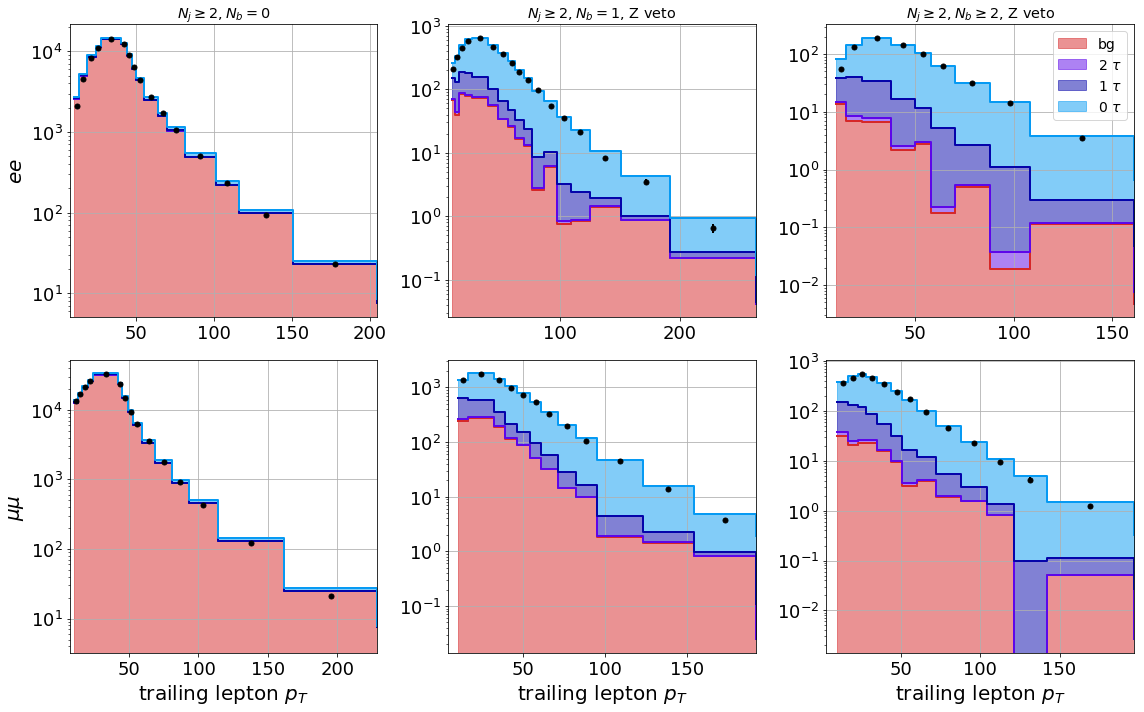

In [4]:
# visualize toy data (ee, mumu)
#fig, axes = plt.subplots(len(pt.categories), len(selections), figsize=(24, 12), facecolor='white')
fig, axes = plt.subplots(2, 3, figsize=(16, 10), facecolor='white')
for i, selection in enumerate(['ee', 'mumu']):
    for j, (category, template_data) in enumerate(fit_data.get_selection_data(selection).items()):
        ax = axes[i][j]
        if i == 0: 
            ax.set_title(pt.categories[category].label)
        
        if i == 1:
            ax.set_xlabel('trailing lepton $p_{T}$')
            
        if j == 0:
            ax.set_ylabel(plot_labels[selection][1])
            
        # get and plot the data 
        templates = template_data['templates']
        bins = template_data['bins'][:-1]
        dx = (bins[1:] - bins[:-1])
        dx = np.append(dx, dx[-1]) 
        x  = bins + dx/2            

        #data = toy_data[selection][category]
        data = templates['data']['val']
        ax.errorbar(x, data/dx, np.sqrt(data)/dx, fmt='ko', linewidth=2., markersize=5)
        
        h_bg      = np.zeros(data.shape)
        h_twotau  = np.zeros(data.shape)
        h_onetau  = np.zeros(data.shape)
        h_nominal = np.zeros(data.shape)
        for dataset, template in templates.items():
            if dataset in ['ttbar', 't']:
                signal_template = pd.DataFrame.from_items([(dm, t['val']) for dm, t in template.items()]) 
                h_twotau  += fh.signal_mixture_model(beta_init, br_tau, signal_template, mask=fit_data._decay_map['sig_twotau'])
                h_onetau  += fh.signal_mixture_model(beta_init, br_tau, signal_template, mask=fit_data._decay_map['sig_onetau'])
                h_nominal += fh.signal_mixture_model(beta_init, br_tau, signal_template)
            elif dataset == 'wjets':
                signal_template = pd.DataFrame.from_items([(dm, t['val']) for dm, t in template.items()]) 
                h_onetau  += fh.signal_mixture_model(beta_init, br_tau, signal_template, mask=np.array([0, 0, 1, 1, 1, 0]), single_w=True)
                h_nominal += fh.signal_mixture_model(beta_init, br_tau, signal_template, single_w=True)
            elif dataset != 'data':
                h_bg += template['val']
                
        h_nominal += h_bg
        h_twotau += h_bg
        h_onetau += h_twotau
        
        ax.plot(bins, h_bg/dx, drawstyle='steps-post', c='C3', linestyle='-', linewidth=2., label='_nolegend_')
        ax.fill_between(bins, h_bg/dx, color='C3', step='post', alpha=0.5, label='bg')
        
        ax.plot(bins, h_twotau/dx, drawstyle='steps-post', c='xkcd:blue violet', linestyle='-', linewidth=2., label='_nolegend_')
        ax.fill_between(bins, h_bg/dx, h_twotau/dx, color='xkcd:blue violet', step='post', alpha=0.5, label=r'2 $\tau$' )
        ax.plot(bins, h_onetau/dx, drawstyle='steps-post', c='xkcd:royal blue', linestyle='-', linewidth=2., label='_nolegend_')
        ax.fill_between(bins, h_twotau/dx, h_onetau/dx, color='xkcd:royal blue', step='post', alpha=0.5, label=r'1 $\tau$')
        ax.plot(bins, h_nominal/dx, drawstyle='steps-post', c='xkcd:azure', linestyle='-', linewidth=2., label='_nolegend')
        ax.fill_between(bins, h_onetau/dx, h_nominal/dx, color='xkcd:azure', step='post', alpha=0.5, label=r'0 $\tau$')
    
        xmin, xmax = bins[0]-dx[0], bins[-2]+dx[-2]
        ax.set_xlim(xmin, xmax)
        #ax.set_ylim(0.01, 10.*np.max(h_nominal[0]/dx))
        ax.set_yscale('log')
        ax.grid()
        
    axes[0][-1].legend(fontsize=14)
    
plt.tight_layout()
plt.savefig('plots/toy_mc_example_ll.pdf')
plt.show()

/home/naodell/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
/home/naodell/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.


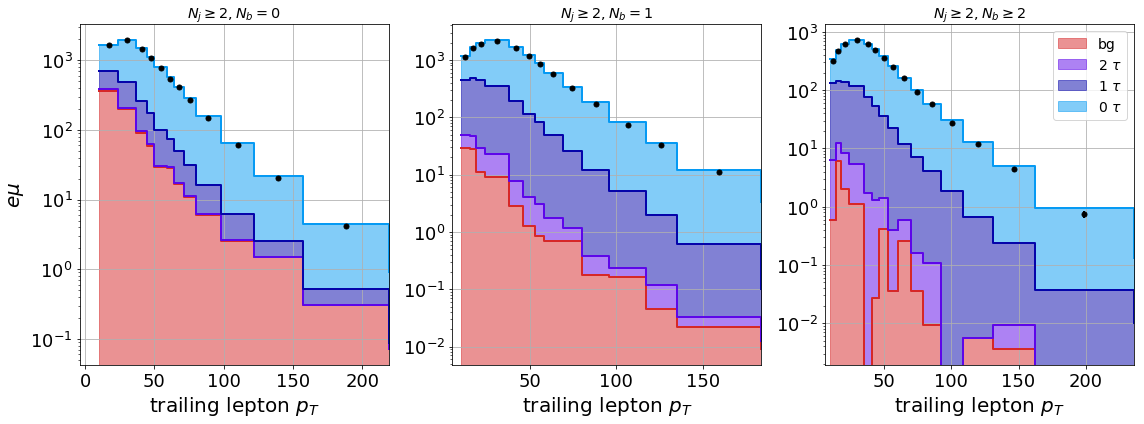

In [5]:
# visualize toy data (emu)
#fig, axes = plt.subplots(len(pt.categories), len(selections), figsize=(24, 12), facecolor='white')
fig, axes = plt.subplots(1, 3, figsize=(16, 6), facecolor='white')

selection = 'emu'
for j, (category, template_data) in enumerate(fit_data.get_selection_data(selection).items()):
    ax = axes[j]
    ax.set_title(pt.categories[category].label)
    ax.set_xlabel('trailing lepton $p_{T}$')
            
    if j == 0:
        ax.set_ylabel(plot_labels[selection][1])

    # get and plot the data 
    templates = template_data['templates']
    bins = template_data['bins'][:-1]
    dx = (bins[1:] - bins[:-1])
    dx = np.append(dx, dx[-1]) 
    x  = bins + dx/2            

    #data = toy_data[selection][category]
    data = templates['data']['val']
    ax.errorbar(x, data/dx, np.sqrt(data)/dx, fmt='ko', linewidth=2., markersize=5)

    h_bg      = np.zeros(data.shape)
    h_twotau  = np.zeros(data.shape)
    h_onetau  = np.zeros(data.shape)
    h_nominal = np.zeros(data.shape)
    for dataset, template in templates.items():
        if dataset in ['ttbar', 't']:
            signal_template = pd.DataFrame.from_items([(dm, t['val']) for dm, t in template.items()]) 
            h_twotau  += fh.signal_mixture_model(beta_init, br_tau, signal_template, mask=fit_data._decay_map['sig_twotau'])
            h_onetau  += fh.signal_mixture_model(beta_init, br_tau, signal_template, mask=fit_data._decay_map['sig_onetau'])
            h_nominal += fh.signal_mixture_model(beta_init, br_tau, signal_template)
        elif dataset == 'wjets':
            signal_template = pd.DataFrame.from_items([(dm, t['val']) for dm, t in template.items()]) 
            h_onetau  += fh.signal_mixture_model(beta_init, br_tau, signal_template, mask=np.array([0, 0, 1, 1, 1, 0]), single_w=True)
            h_nominal += fh.signal_mixture_model(beta_init, br_tau, signal_template, single_w=True)
        elif dataset != 'data':
            h_bg += template['val']

    h_nominal += h_bg
    h_twotau += h_bg
    h_onetau += h_twotau

    ax.plot(bins, h_bg/dx, drawstyle='steps-post', c='C3', linestyle='-', linewidth=2., label='_nolegend_')
    ax.fill_between(bins, h_bg/dx, color='C3', step='post', alpha=0.5, label='bg')

    ax.plot(bins, h_twotau/dx, drawstyle='steps-post', c='xkcd:blue violet', linestyle='-', linewidth=2., label='_nolegend_')
    ax.fill_between(bins, h_bg/dx, h_twotau/dx, color='xkcd:blue violet', step='post', alpha=0.5, label=r'2 $\tau$' )
    ax.plot(bins, h_onetau/dx, drawstyle='steps-post', c='xkcd:royal blue', linestyle='-', linewidth=2., label='_nolegend_')
    ax.fill_between(bins, h_twotau/dx, h_onetau/dx, color='xkcd:royal blue', step='post', alpha=0.5, label=r'1 $\tau$')
    ax.plot(bins, h_nominal/dx, drawstyle='steps-post', c='xkcd:azure', linestyle='-', linewidth=2., label='_nolegend')
    ax.fill_between(bins, h_onetau/dx, h_nominal/dx, color='xkcd:azure', step='post', alpha=0.5, label=r'0 $\tau$')

    xmin, xmax = bins[0]-dx[0], bins[-2]+dx[-2]
    ax.set_xlim(xmin, xmax)
    #ax.set_ylim(0.01, 10.*np.max(h_nominal[0]/dx))
    ax.set_yscale('log')
    ax.grid()

axes[-1].legend(fontsize=14)
    
plt.tight_layout()
plt.savefig('plots/toy_mc_example_emu.pdf')
plt.show()

/home/naodell/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
/home/naodell/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.


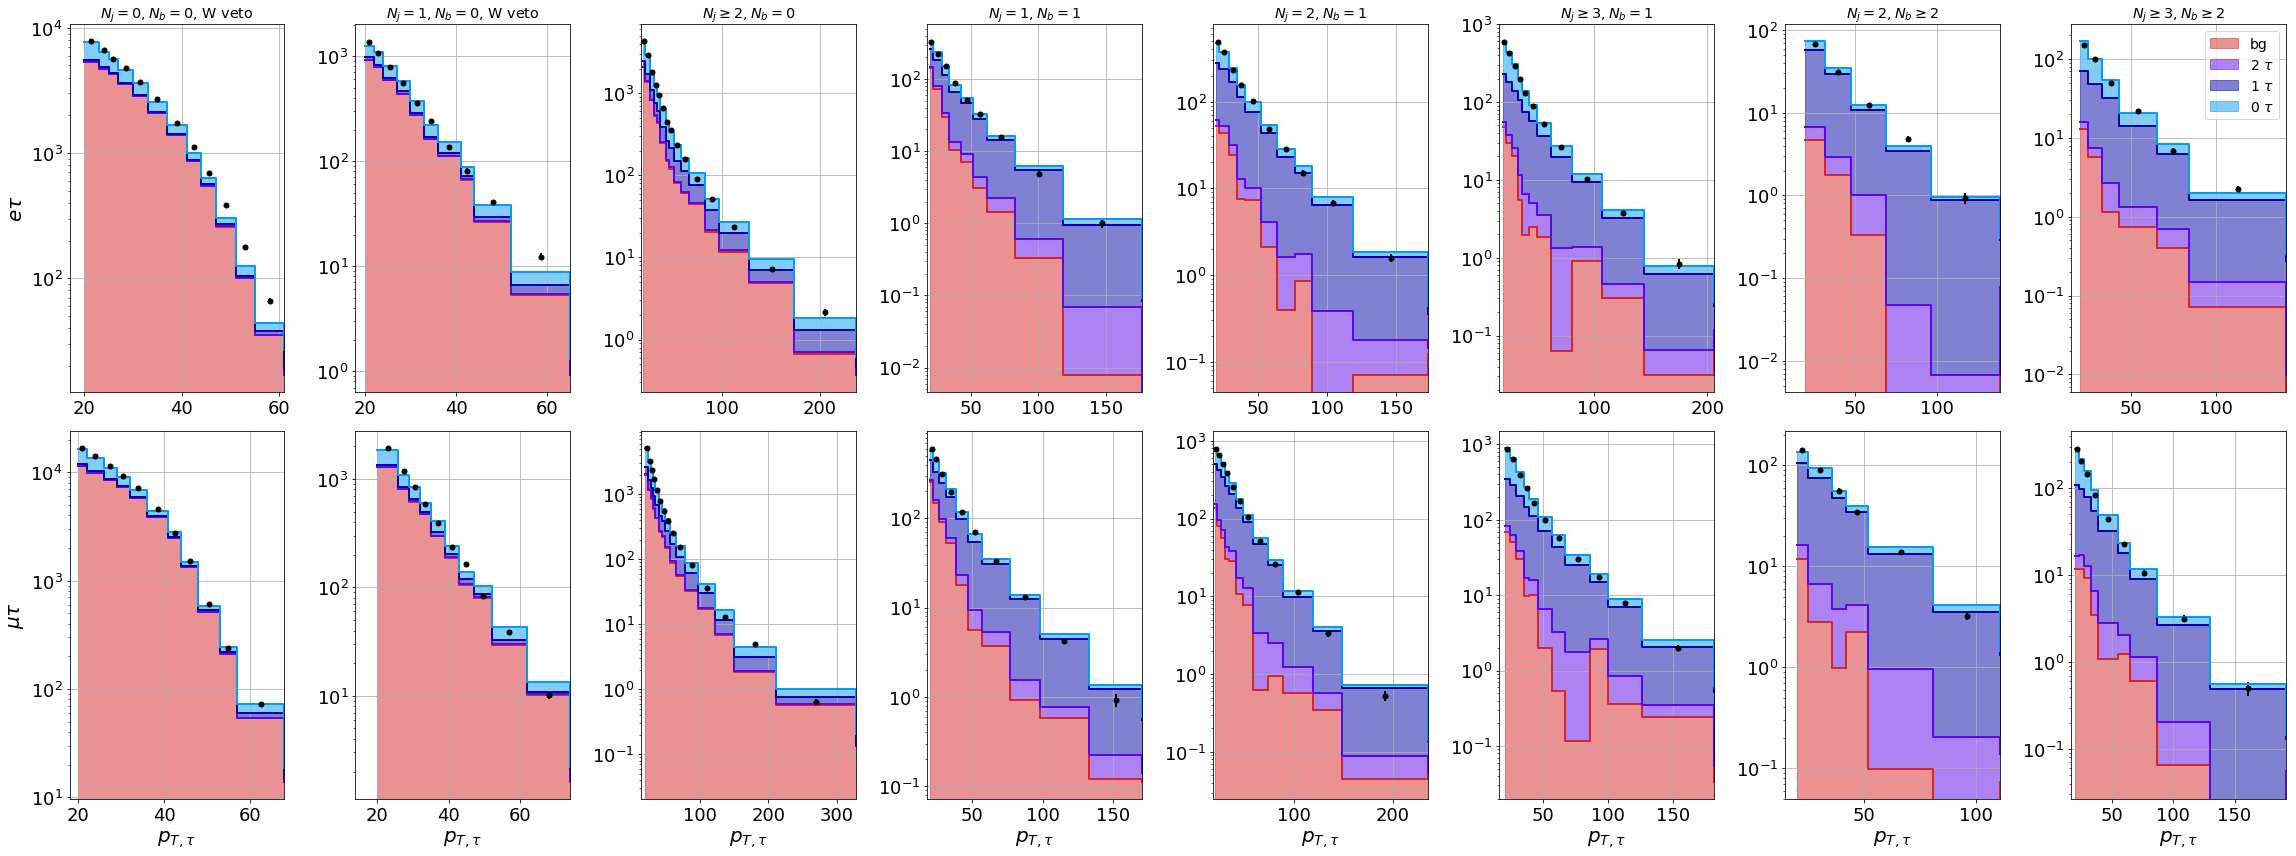

In [6]:
# visualize toy data (mutau, etau)
#fig, axes = plt.subplots(len(pt.categories), len(selections), figsize=(24, 12), facecolor='white')
fig, axes = plt.subplots(2, 8, figsize=(32, 12), facecolor='white')
for i, selection in enumerate(['etau', 'mutau']):
    for j, (category, template_data) in enumerate(fit_data.get_selection_data(selection).items()):
        #print(selection, category)
        
        ax = axes[i][j]
        if i == 0: 
            ax.set_title(pt.categories[category].label)
        
        if i == 1:
            ax.set_xlabel(r'$p_{T, \tau}$')
            
        if j == 0:
            ax.set_ylabel(plot_labels[selection][1])
            
        # get and plot the data 
        templates = template_data['templates']
        bins = template_data['bins'][:-1]
        dx = (bins[1:] - bins[:-1])
        dx = np.append(dx, dx[-1]) 
        x  = bins + dx/2            

        #data = toy_data[selection][category]
        data = templates['data']['val']
        ax.errorbar(x, data/dx, np.sqrt(data)/dx, fmt='ko', linewidth=2., markersize=5)
        
        h_bg      = np.zeros(data.shape)
        h_twotau  = np.zeros(data.shape)
        h_onetau  = np.zeros(data.shape)
        h_nominal = np.zeros(data.shape)
        for dataset, template in templates.items():
            if dataset in ['ttbar', 't']:
                signal_template = pd.DataFrame.from_items([(dm, t['val']) for dm, t in template.items()]) 
                h_twotau  += fh.signal_mixture_model(beta_init, br_tau, signal_template, mask=fit_data._decay_map['sig_twotau'])
                h_onetau  += fh.signal_mixture_model(beta_init, br_tau, signal_template, mask=fit_data._decay_map['sig_onetau'])
                h_nominal += fh.signal_mixture_model(beta_init, br_tau, signal_template)
            elif dataset == 'wjets':
                signal_template = pd.DataFrame.from_items([(dm, t['val']) for dm, t in template.items()]) 
                h_onetau  += fh.signal_mixture_model(beta_init, br_tau, signal_template, mask=np.array([0, 0, 1, 1, 1, 0]), single_w=True)
                h_nominal += fh.signal_mixture_model(beta_init, br_tau, signal_template, single_w=True)
            elif dataset != 'data':
                h_bg += template['val']
                
        h_nominal += h_bg
        h_twotau += h_bg
        h_onetau += h_twotau
        
        ax.plot(bins, h_bg/dx, drawstyle='steps-post', c='C3', linestyle='-', linewidth=2., label='_nolegend_')
        ax.fill_between(bins, h_bg/dx, color='C3', step='post', alpha=0.5, label='bg')
        
        ax.plot(bins, h_twotau/dx, drawstyle='steps-post', c='xkcd:blue violet', linestyle='-', linewidth=2., label='_nolegend_')
        ax.fill_between(bins, h_bg/dx, h_twotau/dx, color='xkcd:blue violet', step='post', alpha=0.5, label=r'2 $\tau$' )
        ax.plot(bins, h_onetau/dx, drawstyle='steps-post', c='xkcd:royal blue', linestyle='-', linewidth=2., label='_nolegend_')
        ax.fill_between(bins, h_twotau/dx, h_onetau/dx, color='xkcd:royal blue', step='post', alpha=0.5, label=r'1 $\tau$')
        ax.plot(bins, h_nominal/dx, drawstyle='steps-post', c='xkcd:azure', linestyle='-', linewidth=2., label='_nolegend')
        ax.fill_between(bins, h_onetau/dx, h_nominal/dx, color='xkcd:azure', step='post', alpha=0.5, label=r'0 $\tau$')
    
        xmin, xmax = bins[0]-dx[0], bins[-2]+dx[-2]
        ax.set_xlim(xmin, xmax)
        #ax.set_ylim(0.01, 10.*np.max(h_nominal[0]/dx))
        ax.set_yscale('log')
        ax.grid()
        
    axes[0][-1].legend(fontsize=14)
    
plt.tight_layout()
plt.savefig('plots/toy_mc_example_ltau.pdf')
plt.show()

/home/naodell/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
/home/naodell/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.


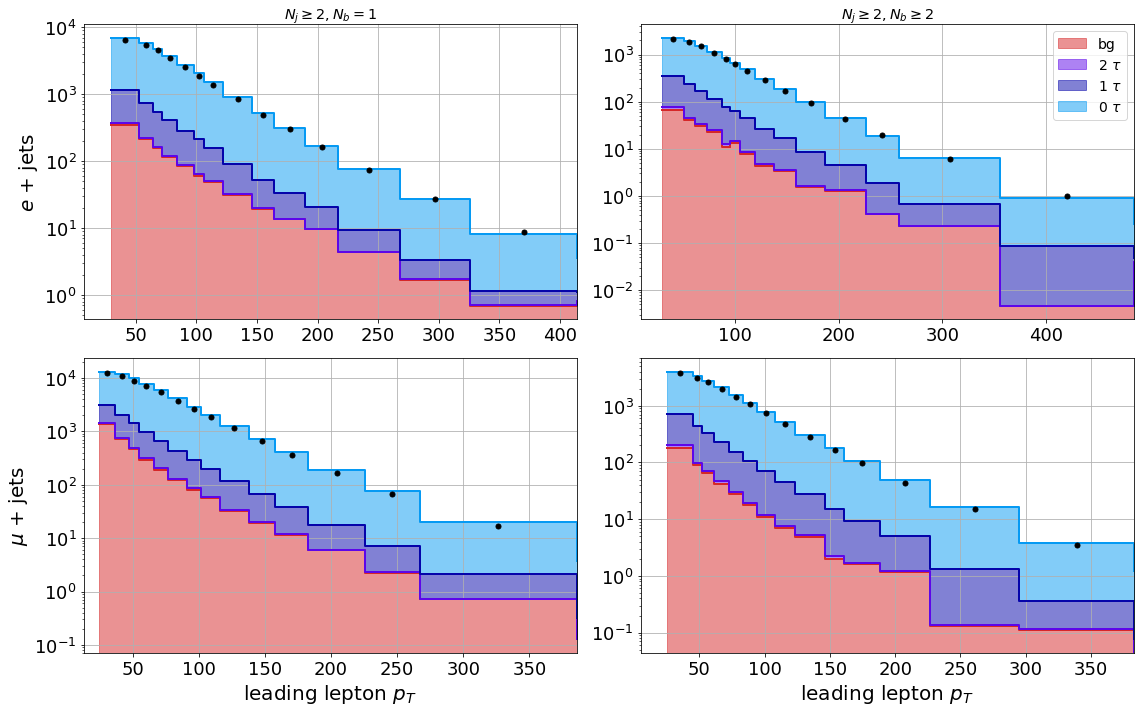

In [7]:
# visualize toy data (e+jet, mu+jet)
#fig, axes = plt.subplots(len(pt.categories), len(selections), figsize=(24, 12), facecolor='white')
fig, axes = plt.subplots(2, 2, figsize=(16, 10), facecolor='white')
for i, selection in enumerate(['e4j', 'mu4j']):
    for j, (category, template_data) in enumerate(fit_data.get_selection_data(selection).items()):
        ax = axes[i][j]
        if i == 0: 
            ax.set_title(pt.categories[category].label)
        
        if i == 1:
            ax.set_xlabel('leading lepton $p_{T}$')
            
        if j == 0:
            ax.set_ylabel(plot_labels[selection][1])
            
        # get and plot the data 
        templates = template_data['templates']
        bins = template_data['bins'][:-1]
        dx = (bins[1:] - bins[:-1])
        dx = np.append(dx, dx[-1]) 
        x  = bins + dx/2            

        #data = toy_data[selection][category]
        data = templates['data']['val']
        ax.errorbar(x, data/dx, np.sqrt(data)/dx, fmt='ko', linewidth=2., markersize=5)
        
        h_bg      = np.zeros(data.shape)
        h_twotau  = np.zeros(data.shape)
        h_onetau  = np.zeros(data.shape)
        h_nominal = np.zeros(data.shape)
        for dataset, template in templates.items():
            if dataset in ['ttbar', 't']:
                signal_template = pd.DataFrame.from_items([(dm, t['val']) for dm, t in template.items()]) 
                h_twotau  += fh.signal_mixture_model(beta_init, br_tau, signal_template, mask=fit_data._decay_map['sig_twotau'])
                h_onetau  += fh.signal_mixture_model(beta_init, br_tau, signal_template, mask=fit_data._decay_map['sig_onetau'])
                h_nominal += fh.signal_mixture_model(beta_init, br_tau, signal_template)
            elif dataset == 'wjets':
                signal_template = pd.DataFrame.from_items([(dm, t['val']) for dm, t in template.items()]) 
                h_onetau  += fh.signal_mixture_model(beta_init, br_tau, signal_template, mask=np.array([0, 0, 1, 1, 1, 0]), single_w=True)
                h_nominal += fh.signal_mixture_model(beta_init, br_tau, signal_template, single_w=True)
            elif dataset != 'data':
                h_bg += template['val']
                
        h_nominal += h_bg
        h_twotau += h_bg
        h_onetau += h_twotau
        
        ax.plot(bins, h_bg/dx, drawstyle='steps-post', c='C3', linestyle='-', linewidth=2., label='_nolegend_')
        ax.fill_between(bins, h_bg/dx, color='C3', step='post', alpha=0.5, label='bg')
        
        ax.plot(bins, h_twotau/dx, drawstyle='steps-post', c='xkcd:blue violet', linestyle='-', linewidth=2., label='_nolegend_')
        ax.fill_between(bins, h_bg/dx, h_twotau/dx, color='xkcd:blue violet', step='post', alpha=0.5, label=r'2 $\tau$' )
        ax.plot(bins, h_onetau/dx, drawstyle='steps-post', c='xkcd:royal blue', linestyle='-', linewidth=2., label='_nolegend_')
        ax.fill_between(bins, h_twotau/dx, h_onetau/dx, color='xkcd:royal blue', step='post', alpha=0.5, label=r'1 $\tau$')
        ax.plot(bins, h_nominal/dx, drawstyle='steps-post', c='xkcd:azure', linestyle='-', linewidth=2., label='_nolegend')
        ax.fill_between(bins, h_onetau/dx, h_nominal/dx, color='xkcd:azure', step='post', alpha=0.5, label=r'0 $\tau$')
    
        xmin, xmax = bins[0]-dx[0], bins[-2]+dx[-2]
        ax.set_xlim(xmin, xmax)
        #ax.set_ylim(0.01, 10.*np.max(h_nominal[0]/dx))
        ax.set_yscale('log')
        ax.grid()
        
    axes[0][-1].legend(fontsize=14)
    
plt.tight_layout()
plt.savefig('plots/toy_mc_example_ljets.pdf')
plt.show()

In [8]:
# initialize data for likelihood scans and calculation of the NLL covariance
params_init = fit_data.get_params_init()
cost_type = 'poisson'
fobj = partial(fit_data.objective, data=toy_data, cost_type=cost_type, no_shape=False)

# calculate covariance matrix from the inverse of the Hessian of the NLL
stderr, corr = fh.calculate_covariance(fobj, params_init)

In [9]:
# plot errors
params = fit_data._parameters
p_labels = list(params.index.values)
params_init = params.val_init.values

pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', len(p_labels))
pd.set_option('display.max_rows', len(p_labels))

pct_err = pd.DataFrame(np.array([100*params_init[:4], 100*stderr[:4], 100*stderr[:4]/params_init[:4]]).T, 
                       index=p_labels[:4], 
                       columns=['params_init', 'stderr', 'stderr (%)']
                      )
pct_err

,params_init,stderr,stderr (%)
beta_e,10.800,0.090,0.834
beta_mu,10.800,0.091,0.839
beta_tau,10.800,0.150,1.390
beta_h,67.600,0.274,0.405


In [10]:
# plot nuisance parameter errors and constraints
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pct_err = pd.DataFrame(np.array([params_init, 100*params.err_init, 100*stderr, params.err_init/stderr]).T, 
                       index=p_labels, 
                       columns=['params_init', 'stderr_pre (%)', 'stderr_post (%)', 'constraint']
                      )
pct_err[4:].to_csv('local_data/pulls.csv')
pct_err[4:]

,params_init,stderr_pre (%),stderr_post (%),constraint
br_tau_e,0.178,0.040,0.040,1.001
br_tau_mu,0.174,0.040,0.040,1.003
br_tau_h,0.648,0.100,0.100,1.002
lumi,1.000,2.500,2.016,1.240
xs_zjets,1.000,10.000,2.699,3.704
xs_diboson,1.000,10.000,8.396,1.191
xs_ttbar,1.000,5.000,2.135,2.342
xs_t,1.000,10.000,6.833,1.463
xs_wjets,1.000,5.000,2.938,1.702
e_fakes,1.000,25.000,11.799,2.119


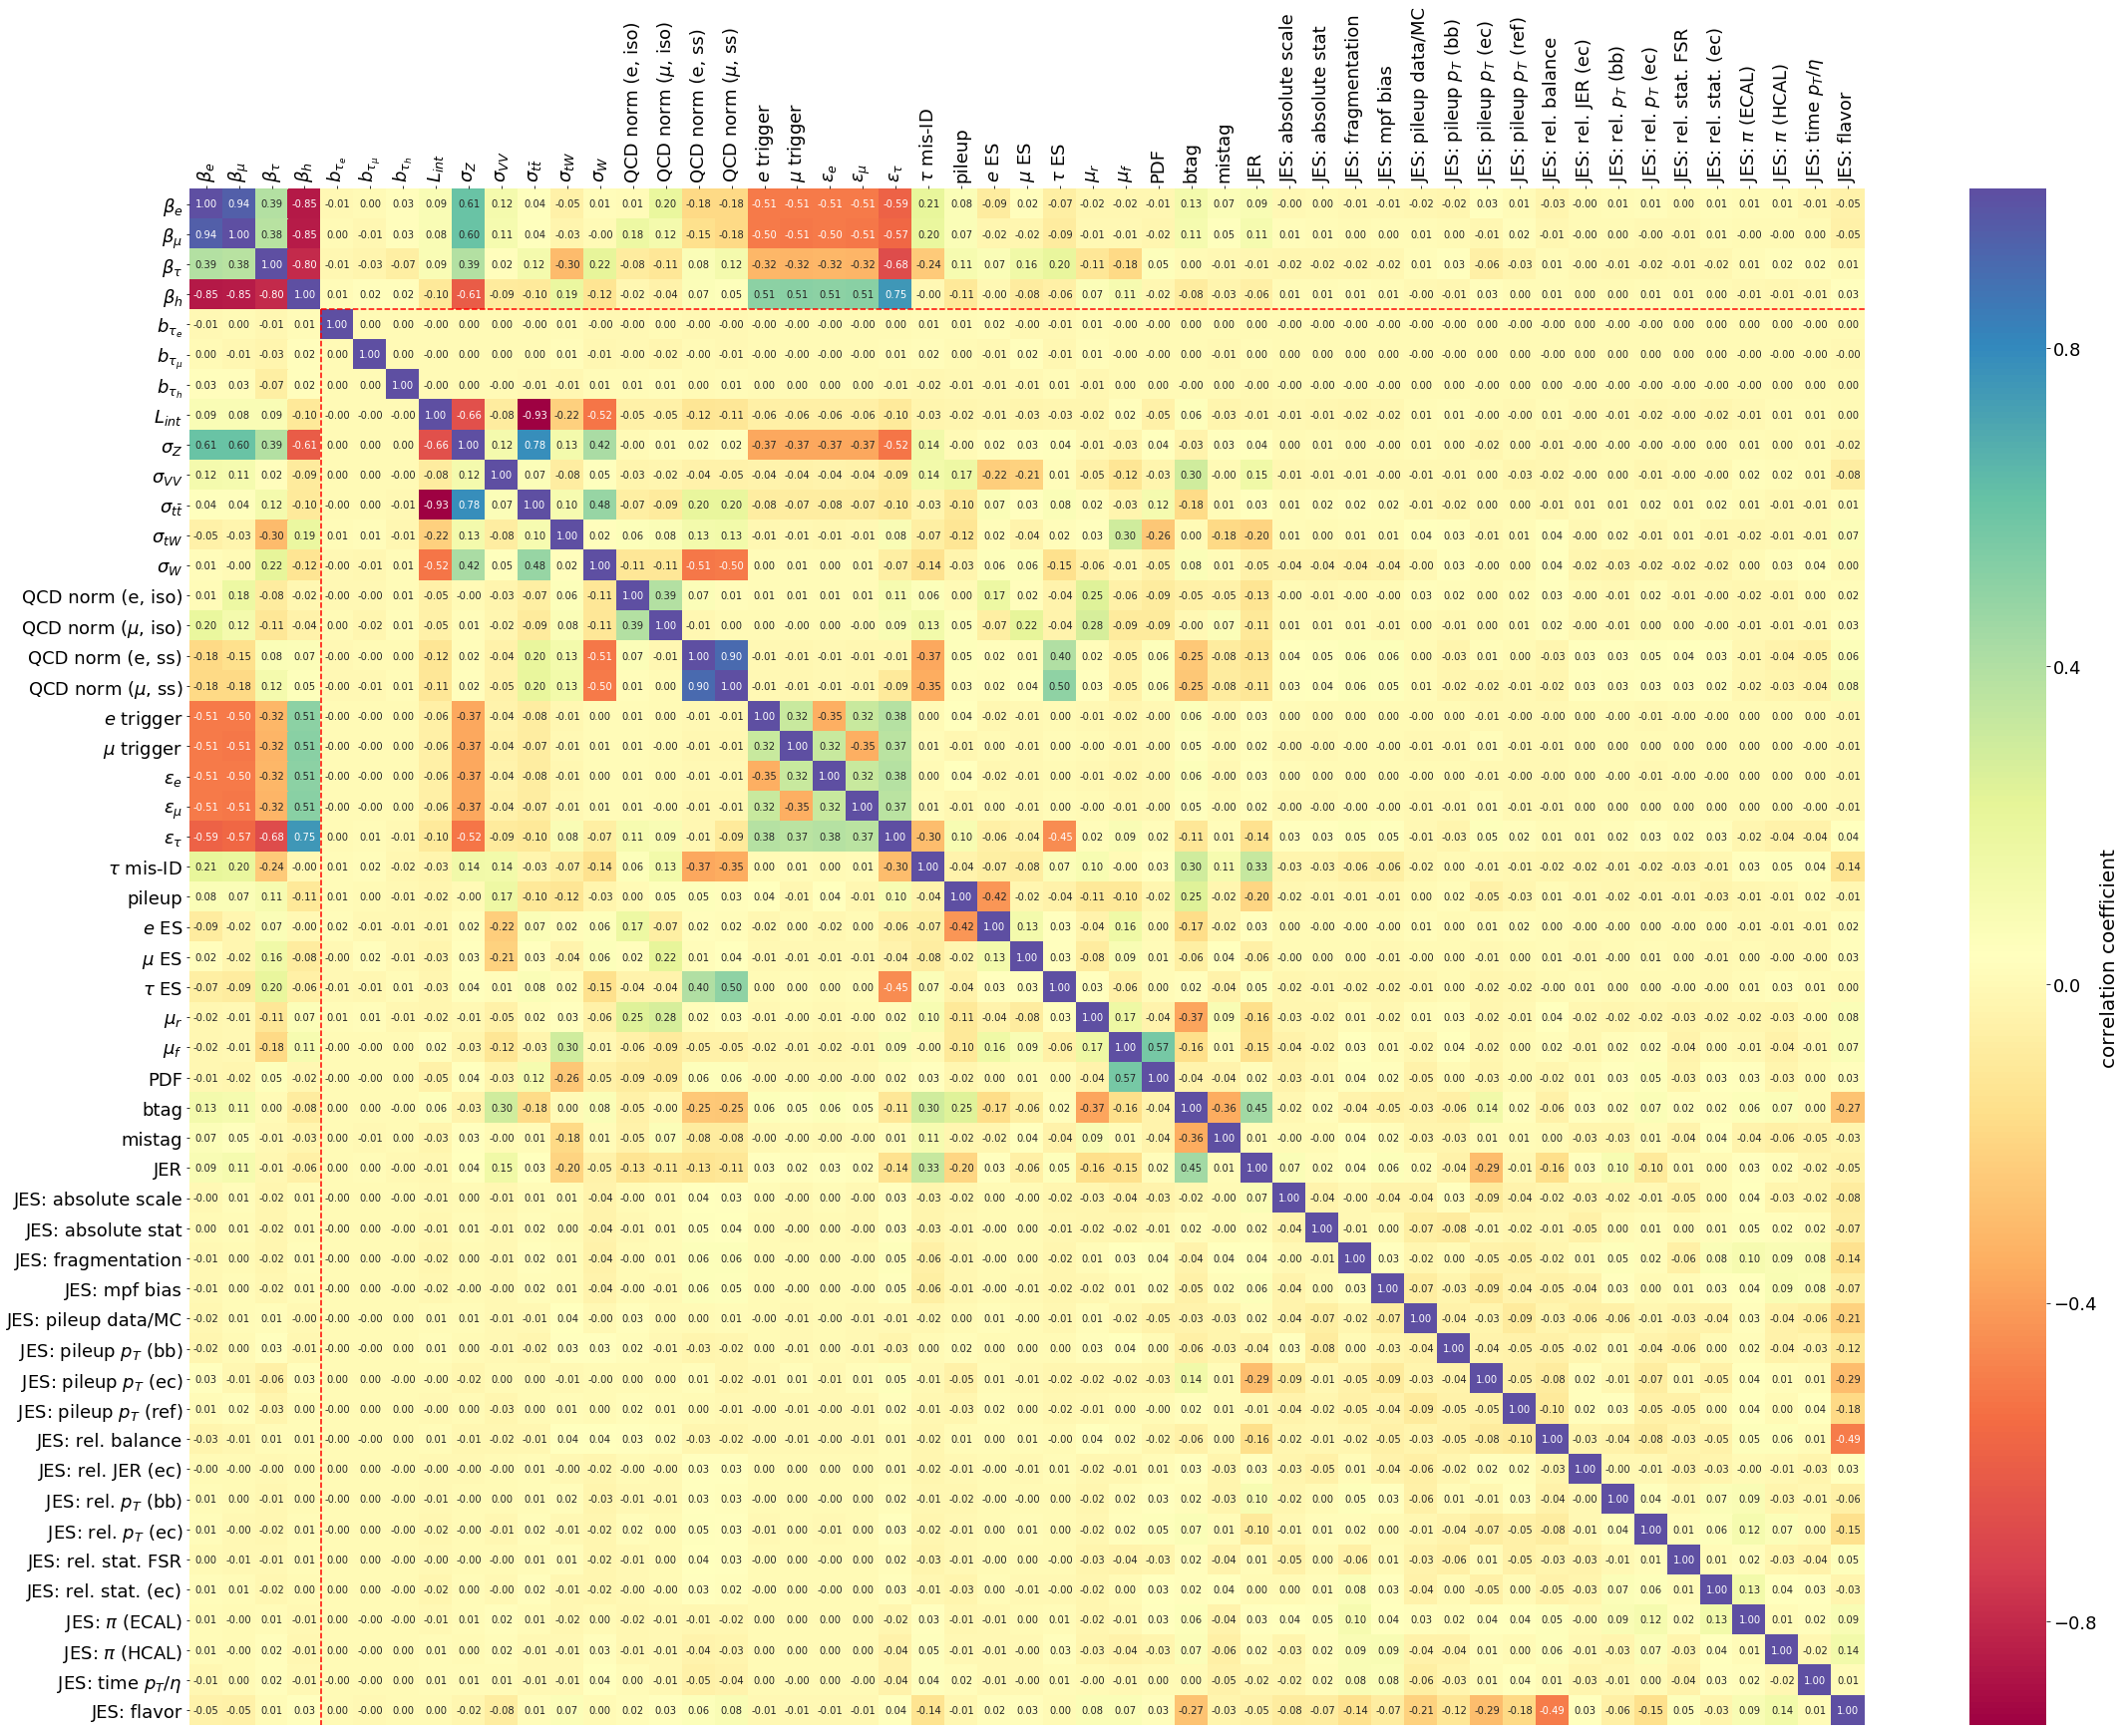

In [11]:
# produce correlation matrix
p_labels_fancy = fit_data._parameters.label
df_corr = pd.DataFrame(corr, columns=p_labels_fancy, index=p_labels_fancy)
df_corr.to_latex('local_data/corr_table_full.tex')
df_corr.to_csv('local_data/corr_table_full.csv')

import seaborn as sns
fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(32, 24))
#fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(12, 8))
sns.heatmap(df_corr, cmap='Spectral', annot=True, fmt='.2f', ax=ax, cbar_kws={'label': r'correlation coefficient'})
plt.plot([4, df_corr.shape[0]], [4, 4], 'r--')
plt.plot([4, 4], [4, df_corr.shape[0]], 'r--')
ax.set_xlabel('')
ax.set_ylabel('')
ax.xaxis.tick_top()
plt.xticks(rotation=90)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.savefig('plots/systematics/correlation_matrix.pdf')
plt.show()

### Estimating individual contributions

If we make the assumption that the uncertainties sum in quadrature (which they should really given all of the correlations), we can write the total uncertainty as,

$$
\sigma_{total}^{2} = \sigma_{stat}^{2} + \sum_{i}\sigma_{i,syst}^{2}
$$

From this we can write evaluate the contribution from a single systematic source as,

$$
\sigma_{i,syst}^{2} = \sigma_{total}^{2} - \sigma_{stat}^{2} - \sum_{j\neq i}\sigma_{j,syst}^{2}
$$


In [12]:
# n-1 uncertainties
from tqdm import tqdm_notebook, trange
from multiprocessing import Pool

def reduced_objective(p, mask, p_init):
    masked_p = p_init.copy()
    masked_p[mask] = p
    return fit_data.objective(masked_p, data=toy_data, cost_type=cost_type, no_shape=False)

# stat only
mask = np.ones(len(params_init)).astype(bool)
mask[4:] = False
fobj = partial(reduced_objective, mask=mask, p_init=params_init)
err_stat, _ = fh.calculate_covariance(fobj, params_init[:4])
err_stat = np.concatenate([err_stat, np.zeros(params_init[4:].size)])

# n-1 systematics
pool = Pool(processes=12)
results = []
for i in range(4, len(params_init)):
    mask = np.ones(len(params_init)).astype(bool)
    mask[i] = False
    fobj = partial(reduced_objective, mask=mask, p_init=params_init)
    res = pool.apply_async(fh.calculate_covariance, args=(fobj, np.delete(params_init, i)))
    results.append(res)
    
pool.close()
pool.join()

output = [r.get() for r in results]

In [13]:
# convert to errors
sub_errs = [o[0] for o in output]
errs = np.array([np.concatenate([sub_errs[i-4][:i], [0], sub_errs[i-4][i:]]) for i in range(4, params_init.size)])
errs = np.vstack([err_stat, errs, stderr])
errs = pd.DataFrame(errs, columns=p_labels, index=['stat only'] + p_labels[4:] + ['full'])
errs.multiply(100)

,beta_e,beta_mu,beta_tau,beta_h,br_tau_e,br_tau_mu,br_tau_h,lumi,xs_zjets,xs_diboson,xs_ttbar,xs_t,xs_wjets,e_fakes,mu_fakes,e_fakes_ss,mu_fakes_ss,trigger_e,trigger_mu,eff_e,eff_mu,eff_tau,misid_tau_h,pileup,escale_e,escale_mu,escale_tau,mur,muf,pdf,btag,mistag,jer,jes_abs_scale,jes_abs_stat,jes_fragmentation,jes_abs_mpf_bias,jes_pileup_data_mc,jes_pileup_pt_bb,jes_pileup_pt_ec1,jes_pileup_pt_ref,jes_relative_bal,jes_relative_jer_ec1,jes_relative_pt_bb,jes_relative_pt_ec1,jes_relative_stat_fsr,jes_relative_stat_ec,jes_single_pion_ecal,jes_single_pion_hcal,jes_time_pt_eta,jes_flavor_qcd
stat only,0.013,0.011,0.058,0.055,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
br_tau_e,0.090,0.091,0.150,0.274,0.000,0.040,0.100,2.016,2.699,8.396,2.135,6.833,2.938,11.799,4.181,2.343,3.900,0.862,0.862,0.862,0.862,1.454,1.624,22.226,11.573,18.357,7.895,39.623,41.095,83.433,13.779,80.697,43.895,98.094,97.218,103.099,101.369,97.267,97.546,93.934,97.085,88.735,98.572,99.363,101.363,97.701,103.382,102.955,96.701,99.239,68.920
br_tau_mu,0.090,0.091,0.150,0.274,0.040,0.000,0.100,2.016,2.699,8.396,2.135,6.833,2.938,11.799,4.180,2.343,3.900,0.862,0.862,0.862,0.862,1.454,1.624,22.227,11.574,18.353,7.894,39.621,41.095,83.433,13.779,80.694,43.895,98.094,97.218,103.099,101.368,97.267,97.546,93.934,97.085,88.735,98.572,99.363,101.362,97.701,103.381,102.955,96.701,99.239,68.920
br_tau_h,0.090,0.091,0.150,0.274,0.040,0.040,0.000,2.016,2.699,8.396,2.134,6.832,2.938,11.799,4.181,2.343,3.900,0.862,0.862,0.862,0.862,1.454,1.624,22.227,11.574,18.356,7.894,39.620,41.095,83.433,13.779,80.696,43.895,98.094,97.218,103.099,101.369,97.267,97.546,93.934,97.085,88.734,98.572,99.363,101.363,97.701,103.381,102.955,96.701,99.239,68.920
lumi,0.090,0.090,0.150,0.273,0.040,0.040,0.100,0.000,2.019,8.369,0.780,6.667,2.505,11.783,4.175,2.326,3.875,0.861,0.861,0.861,0.861,1.447,1.623,22.223,11.573,18.349,7.892,39.615,41.087,83.320,13.758,80.661,43.893,98.089,97.207,103.079,101.357,97.266,97.537,93.934,97.084,88.729,98.571,99.359,101.350,97.701,103.364,102.953,96.698,99.234,68.920
xs_zjets,0.072,0.072,0.138,0.216,0.040,0.040,0.100,1.508,0.000,8.336,1.323,6.773,2.666,11.799,4.181,2.342,3.899,0.802,0.802,0.802,0.802,1.245,1.607,22.227,11.572,18.347,7.887,39.623,41.081,83.378,13.771,80.649,43.860,98.093,97.215,103.099,101.369,97.265,97.546,93.913,97.085,88.730,98.571,99.363,101.363,97.701,103.380,102.950,96.701,99.236,68.908
xs_diboson,0.089,0.090,0.150,0.273,0.040,0.040,0.100,2.009,2.680,0.000,2.129,6.814,2.935,11.794,4.180,2.341,3.896,0.862,0.862,0.862,0.862,1.448,1.608,21.918,11.279,17.957,7.894,39.572,40.807,83.392,13.128,80.697,43.407,98.084,97.213,103.096,101.368,97.265,97.544,93.934,97.054,88.723,98.572,99.362,101.353,97.701,103.381,102.932,96.687,99.233,68.724
xs_ttbar,0.090,0.091,0.149,0.273,0.040,0.040,0.100,0.737,1.673,8.376,0.000,6.797,2.583,11.774,4.165,2.295,3.818,0.860,0.860,0.860,0.860,1.446,1.623,22.104,11.543,18.350,7.872,39.617,41.073,82.870,13.565,80.696,43.869,98.090,97.204,103.076,101.354,97.264,97.529,93.934,97.085,88.727,98.568,99.358,101.349,97.699,103.360,102.949,96.700,99.235,68.915
xs_t,0.090,0.091,0.143,0.269,0.040,0.040,0.100,1.967,2.676,8.373,2.123,0.000,2.937,11.775,4.169,2.322,3.865,0.862,0.862,0.862,0.862,1.449,1.620,22.074,11.573,18.344,7.894,39.608,39.172,80.609,13.779,79.385,42.996,98.089,97.218,103.094,101.363,97.207,97.499,93.932,97.084,88.669,98.571,99.347,101.361,97.693,103.375,102.938,96.699,99.234,68.762
xs_wjets,0.090,0.091,0.146,0.272,0.040,0.040,0.100,1.719,2.450,8.386,1.877,6.831,0.000,11.728,4.155,2.009,3.374,0.862,0.862,0.862,0.862,1.451,1.607,22.215,11.557,18.324,7.806,39.562,41.095,83.318,13.740,80.695,43.846,98.019,97.143,103.000,101.303,97.266,97.488,93.934,97.085,88.672,98.553,99.321,101.333,97.678,

In [14]:
# print table
beta_vars = errs.iloc[:,:4]**2

for i in trange(1, beta_vars.shape[0] - 1):
    dvar = beta_vars.iloc[-1] - beta_vars.iloc[i]
    beta_vars.iloc[i] = dvar 
    
beta_syst = beta_vars.iloc[-1] - beta_vars.iloc[0]
beta_syst.name = 'syst'
beta_errs = beta_vars.iloc[:-1]
beta_errs = beta_errs.append(beta_syst)
beta_errs = beta_errs.append(beta_vars.iloc[-1])
beta_errs = np.sqrt(beta_errs)

beta_errs.divide(params_init[:4]/100, axis=1).to_latex('local_data/errors.tex')
beta_errs.divide(params_init[:4]/100, axis=1)

100%|██████████| 47/47 [00:00<00:00, 3419.82it/s]


,beta_e,beta_mu,beta_tau,beta_h
stat only,0.122,0.103,0.540,0.081
br_tau_e,0.009,0.003,0.016,0.003
br_tau_mu,0.002,0.010,0.042,0.008
br_tau_h,0.022,0.022,0.099,0.009
lumi,0.071,0.067,0.119,0.041
xs_zjets,0.505,0.507,0.544,0.249
xs_diboson,0.099,0.094,0.032,0.036
xs_ttbar,0.037,0.036,0.169,0.039
xs_t,0.041,0.027,0.420,0.078
xs_wjets,0.012,0.002,0.306,0.050
